In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Suspicous Activity Detection

<img src="./img/bellcurve.jpg" alt="bc" height="400" width="400">

- Use price overide counts
- Detect if any manager does this 3-std deviations of the norm


## Memory Considerations

- Limit the information consumed by **Panadas**
- Only Use Needed Columns

- Use a Bigger Machine

In [2]:
df = pd.read_csv('./data/FACT_Sites_2017.csv',
                 na_values='NULL',
                 parse_dates=True, 
                 usecols=['Site', 'Location', 'businessDate', 
                          'transDatetime','recordID', 
                          'checkEmployeeID',  'managerEmployeeID', 
                          'voidFlag', 'reasonCode', 'priceOvrdeFlag'])

In [3]:
df.voidFlag = df.voidFlag.astype(bool)
df.priceOvrdeFlag = df.priceOvrdeFlag.astype(bool)

In [4]:
df.loc[df.managerEmployeeID.notnull(), 'managerEmployeeID'] = \
df.loc[df.managerEmployeeID.notnull(), 'managerEmployeeID'].astype(int).astype(str)

In [5]:
df.head(2)

,Site,Location,businessDate,transDatetime,recordID,checkEmployeeID,managerEmployeeID,voidFlag,reasonCode,priceOvrdeFlag
0,Site1,C04 LIBERTY GRLL,2017-01-01 00:00,2017-01-01 14:00:31.000,813258.0,841293.0,NaN,False,0.0,True
1,Site1,C04 LIBERTY GRLL,2017-01-01 00:00,2017-01-01 14:33:15.000,812892.0,841293.0,NaN,False,0.0,True


In [6]:
df[df.managerEmployeeID.notnull() & ((df.priceOvrdeFlag.notnull()) | (df.voidFlag.notnull()))]['Site'].value_counts()

Site2    33171
Site1     1762
Name: Site, dtype: int64

##  Convert Data into Workable Format

- Pivot the table to summarize by day and manager


In [15]:
q = ((df.priceOvrdeFlag == True) | (df.voidFlag == True)) & (df.managerEmployeeID.notnull())
pivot_df = df[q].pivot_table(index='managerEmployeeID', 
                             columns='businessDate', 
                             values=['priceOvrdeFlag'], #, 'voidFlag'
                             aggfunc='count')

In [16]:
pivot_df.head(2)

priceOvrdeFlag                                    \
businessDate      2016-08-06 00:00 2016-08-09 00:00 2016-08-11 00:00   
managerEmployeeID                                                      
18177424                       NaN              NaN              NaN   
18236719                       NaN              NaN              8.0   

                                                                      \
businessDate      2016-09-01 00:00 2016-09-02 00:00 2016-09-10 00:00   
managerEmployeeID                                                      
18177424                       NaN              NaN              NaN   
18236719                       NaN              NaN              NaN   

                                                                      \
businessDate      2016-09-11 00:00 2016-09-12 00:00 2016-09-24 00:00   
managerEmployeeID                                                      
18177424                       NaN              NaN              NaN   
18236719                       NaN              NaN              NaN   

                                         ...                          \
businessDate      2016-09-25 00:00       ...        2017-09-18 00:00   
managerEmployeeID                        ...                           
18177424                       NaN       ...                     NaN   
18236719                       NaN       ...                     NaN   

                                                                      \
businessDate      2017-09-19 00:00 2017-09-20 00:00 2017-09-21 00:00   
managerEmployeeID                                                      
18177424                       NaN              NaN              NaN   
18236719                       NaN              NaN              NaN   

                                                                      \
businessDate      2017-09-23 00:00 2017-09-25 00:00 2017-09-26 00:00   
managerEmployeeID                                                      
18177424                       NaN              NaN              NaN   
18236719                       NaN              NaN              NaN   

                                                                      
businessDate      2017-09-27 00:00 2017-09-29 00:00 2017-09-30 00:00  
managerEmployeeID                                                     
18177424                       NaN              NaN              NaN  
18236719                       NaN              NaN              NaN  

[2 rows x 129 columns]

## Calculate the Top 20 Void Managers

- Show managers who perform high number of voids

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


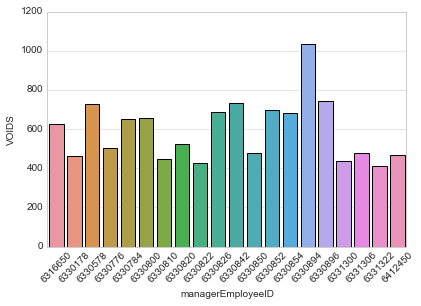

In [17]:
top20 = pivot_df.sum(axis=1).nlargest(20)
sns.set_style("whitegrid")
top20.name = "VOIDS"
top20_df = top20.to_frame()
top20_df['AVERAGE'] = pivot_df.sum(axis=1).mean()
top20_df.sort_values("VOIDS", inplace=True, ascending=False)
top20_df.reset_index(inplace=True, drop=False)

g = sns.barplot(x="managerEmployeeID", y="VOIDS",               
                data=top20_df.astype(int))
plt.tight_layout()
plt.xticks(rotation=45)
print()

## Calculating Suspiciousness as a Metric


<b/>

<img src='./img/thief.jpg' />




- Determines if the managers are constantly voiding items


## Calculating Suspiciousness as a Metric (cont)

- Find the Daily Mean
    - If greater than mean then mark the day
    - Then pull managers who show potential large number of voids
    

### 1. Calculate the days with questionable activity

- Use the average of all days

In [18]:
keeps_cols = []
mean = pivot_df.mean().mean()
for col in pivot_df.columns:
    q = pivot_df[col] >= mean
    s = pivot_df.loc[q, col]
    if len(s) > 0:
        keeps_cols.append(col)

In [19]:
print([col for col in pivot_df.columns])

[('priceOvrdeFlag', '2016-08-06 00:00'), ('priceOvrdeFlag', '2016-08-09 00:00'), ('priceOvrdeFlag', '2016-08-11 00:00'), ('priceOvrdeFlag', '2016-09-01 00:00'), ('priceOvrdeFlag', '2016-09-02 00:00'), ('priceOvrdeFlag', '2016-09-10 00:00'), ('priceOvrdeFlag', '2016-09-11 00:00'), ('priceOvrdeFlag', '2016-09-12 00:00'), ('priceOvrdeFlag', '2016-09-24 00:00'), ('priceOvrdeFlag', '2016-09-25 00:00'), ('priceOvrdeFlag', '2016-09-26 00:00'), ('priceOvrdeFlag', '2016-09-27 00:00'), ('priceOvrdeFlag', '2016-09-29 00:00'), ('priceOvrdeFlag', '2016-10-01 00:00'), ('priceOvrdeFlag', '2016-10-07 00:00'), ('priceOvrdeFlag', '2016-10-09 00:00'), ('priceOvrdeFlag', '2016-10-12 00:00'), ('priceOvrdeFlag', '2016-10-21 00:00'), ('priceOvrdeFlag', '2016-10-22 00:00'), ('priceOvrdeFlag', '2016-10-23 00:00'), ('priceOvrdeFlag', '2016-10-29 00:00'), ('priceOvrdeFlag', '2016-11-10 00:00'), ('priceOvrdeFlag', '2016-11-13 00:00'), ('priceOvrdeFlag', '2016-11-26 00:00'), ('priceOvrdeFlag', '2016-11-28 00:00'),

### 2. Flag Managers Outside the Norm

In [20]:
tracker = {}
for col in keeps_cols:
    q = pivot_df[col] >= pivot_df[keeps_cols].describe().iloc[6][col]
    for manager_id in pivot_df[q].index.tolist():
        if manager_id in tracker:
            tracker[manager_id] += 1
        else:
            tracker[manager_id] = 1

### 3. Find the Biggest Offenders

In [21]:
df_final = pd.DataFrame(list(zip(tracker.keys(), tracker.values())), columns=["MANAGERID", "COUNTS"])
df_final.MANAGERID = df_final.MANAGERID.astype(int).astype(str)
df_final.describe()

,COUNTS
count,135.000000
mean,8.511111
std,11.370206
min,1.000000
25%,1.000000
50%,3.000000
75%,10.500000
max,54.000000


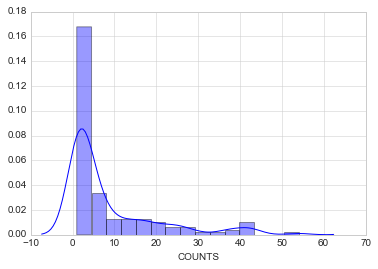

In [22]:
sns.distplot(df_final['COUNTS'])

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


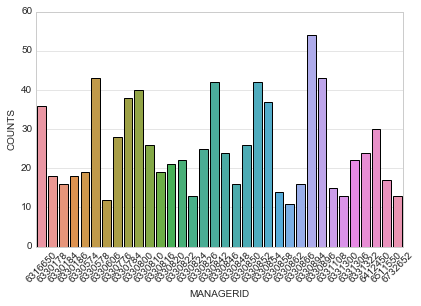

In [29]:
check_managers = df_final[df_final.COUNTS > df_final.describe().iloc[6][0]].copy()
check_managers.sort_values("COUNTS", inplace=True, ascending=False)
check_managers.reset_index(inplace=True, drop=True)

g = sns.barplot(x="MANAGERID", y="COUNTS",               
                data=check_managers)
g.legend = True
plt.tight_layout()
ticks = plt.xticks(rotation=45)

## Top Offender


check_managers.head(5)

In [56]:
q = np.abs(df_final.COUNTS - df_final.COUNTS.mean()) > (3 * df_final.COUNTS.std())

In [57]:
df_final[q]

,MANAGERID,COUNTS
18,6330896,43
77,6330894,54
90,6330578,43


In [54]:
df_final.describe().iloc[6][0]

COUNTS    10.5
Name: 75%, dtype: float64

# Questions?